In [1]:
import sys
sys.path.insert(0, "/home/broerman/crispy_shifty/")
from crispy_shifty.utils.io import gen_array_tasks

design_list_file = "/home/broerman/crispy_shifty/projects/DAB/round_1/design/03_fold_complex/folded_structures.list"

simulation_name = "04_fold_monomer"
output_path = f"/home/broerman/crispy_shifty/projects/DAB/round_1/design/{simulation_name}"

options = " ".join(
    [
        "out:level 100",
    ]
)
extra_kwargs = {"models": "all", "score_prefix": "X_", "chains_to_fold": "1", "df_scores": "/home/broerman/crispy_shifty/projects/DAB/round_1/design/03_fold_complex/scores_df.csv"}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.folding.fold_general",
    design_list_file=design_list_file,
    output_path=output_path,
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    sha1=None,
    cores=1,
    memory="6G",
    queue="cpu",
    time="4:00:00",
)

Run the following command with your desired environment active:
sbatch -a 1-731 /home/broerman/crispy_shifty/projects/DAB/round_1/design/04_fold_monomer/run.sh


In [1]:
import os
import sys
sys.path.insert(0, "/home/broerman/crispy_shifty")

simulation_name = "04_fold_monomer"
output_path = f"/home/broerman/crispy_shifty/projects/DAB/round_1/design/{simulation_name}"

In [2]:
from crispy_shifty.utils.io import collect_score_file

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

In [3]:
from crispy_shifty.utils.io import parse_scorefile_linear

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/3655 [00:00<?, ?it/s]

In [17]:
previous_scores_df = pd.read_csv("/home/broerman/crispy_shifty/projects/DAB/round_1/design/03_fold_complex/scores.csv", index_col=0)

In [10]:
import numpy as np
scores_df["designed_by"] = np.where(scores_df["designed_by"] == "mpnn", "mpnn", "inpainting")

In [18]:
# get parent pdb path and also update with the Y af2 scores that I screwed up getting with df_scores
import pyrosetta.distributed.cluster as cluster
from tqdm.auto import tqdm

Y_cols = ['Y_mean_pae', 'Y_mean_pae_interaction', 'Y_mean_pae_interaction_AB', 'Y_mean_pae_interaction_BA', 'Y_mean_pae_intra_chain', 'Y_mean_pae_intra_chain_A', 'Y_mean_pae_intra_chain_B', 'Y_mean_plddt', 'Y_model', 'Y_pTMscore', 'Y_recycles', 'Y_rmsd_to_reference', 'Y_seed', 'Y_tol']

for path in tqdm(scores_df.index):
    pdb_path = cluster.get_scores_dict(path)["instance"]["tasks"]["pdb_path"]
    scores_df.loc[path, "input_pdb"] = pdb_path
    scores_df.loc[path, Y_cols] = previous_scores_df.loc[pdb_path, Y_cols]

  0%|          | 0/3655 [00:00<?, ?it/s]

In [2]:
import pandas as pd

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col=0)

5it [00:00, 17.33it/s]


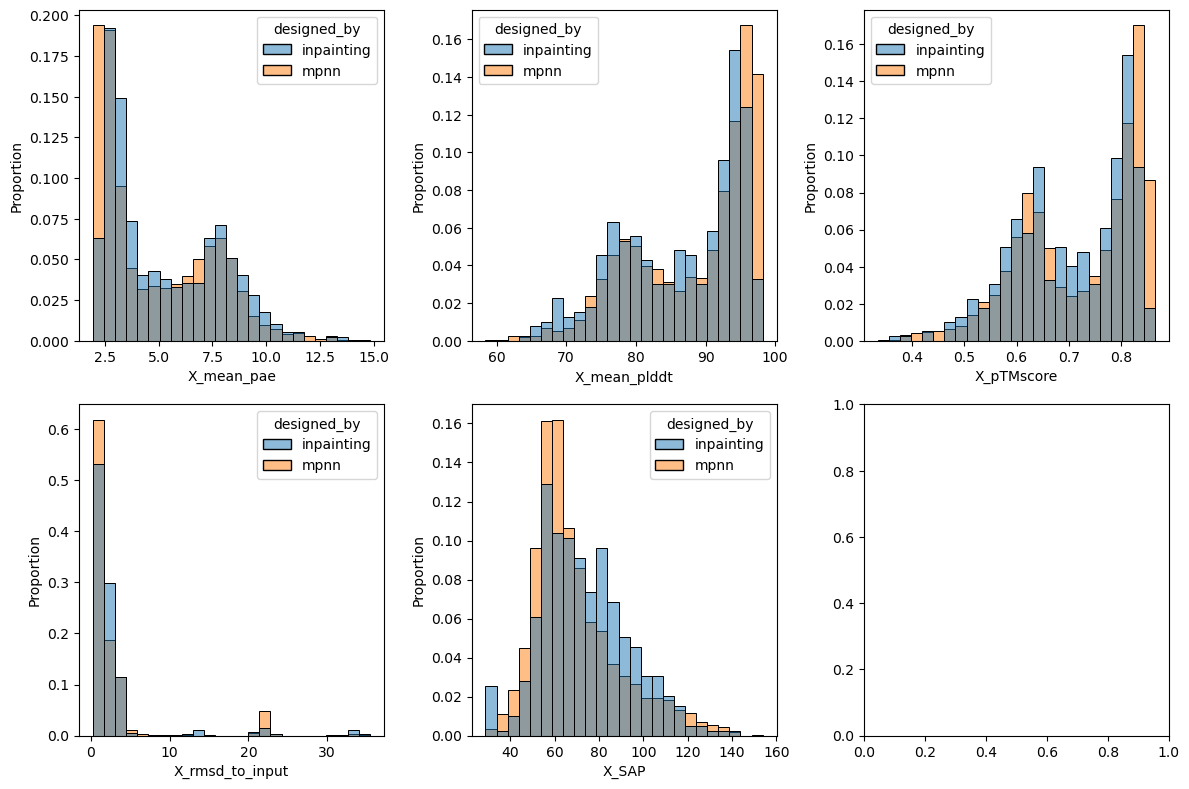

In [3]:
import matplotlib.pyplot as plt
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

cols = [
    "X_mean_pae",
    "X_mean_plddt",
    "X_pTMscore",
    "X_rmsd_to_input",
    "X_SAP"
]
the_fig = histplot_df(
    df=scores_df,
    cols=cols,
    bins=25,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)
plt.savefig(os.path.join(output_path, "af2_scores_all.png"))

5it [00:00, 16.48it/s]


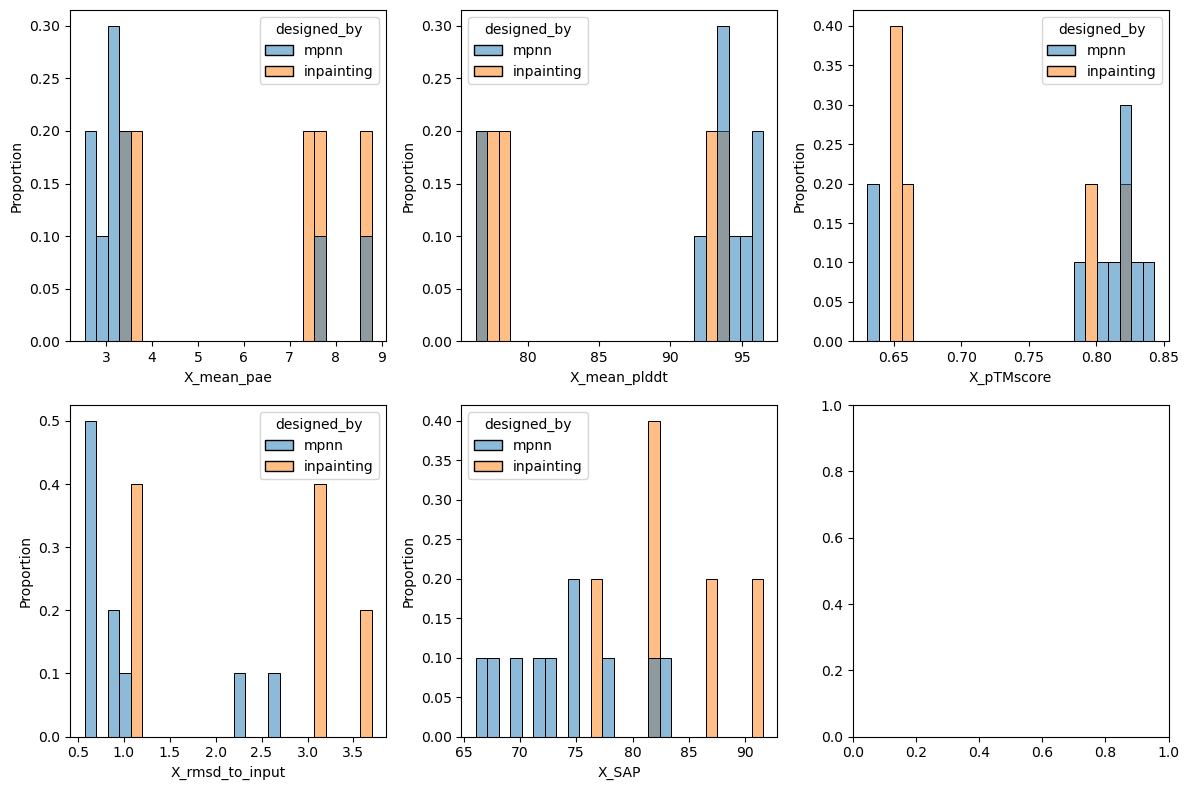

In [25]:
the_fig = histplot_df(
    df=scores_df.query("parent=='cs_201r1'"),
    cols=cols,
    bins=25,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)

5it [00:00, 27.07it/s]


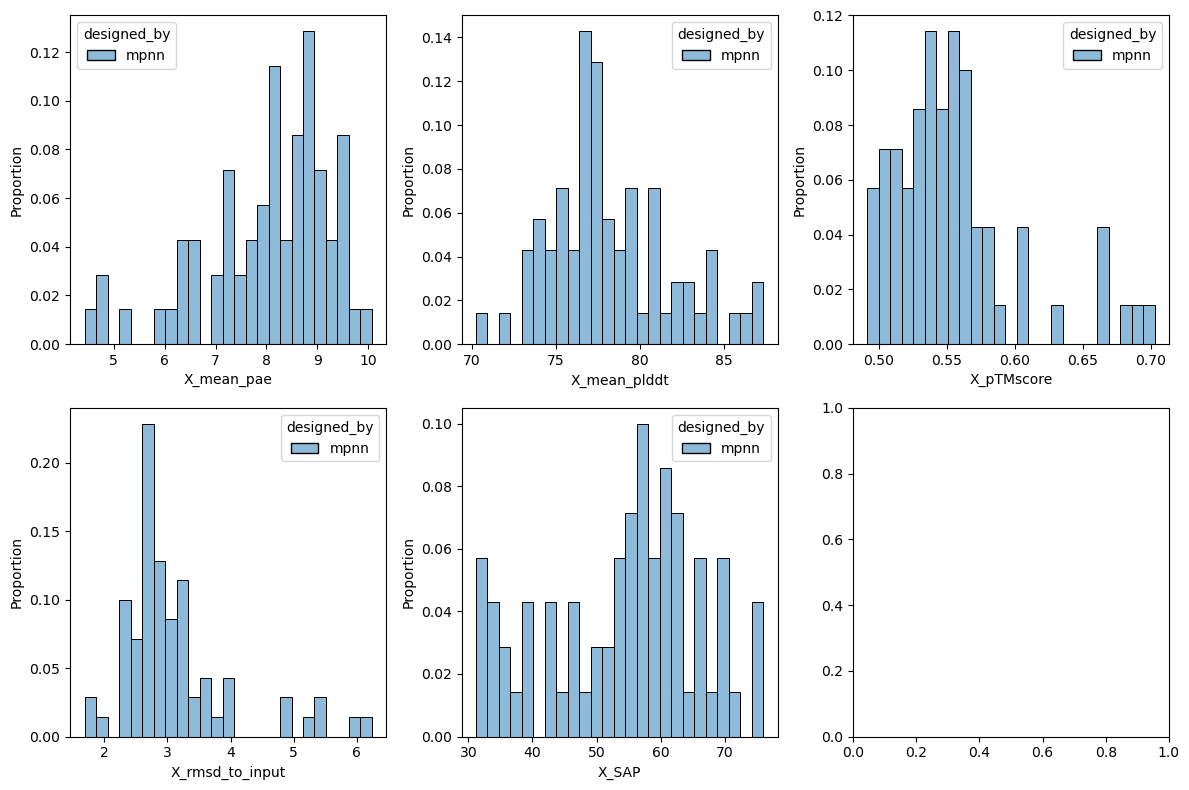

In [28]:
the_fig = histplot_df(
    df=scores_df.query("parent=='cs_242'"),
    cols=cols,
    bins=25,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)

In [4]:
filtered_df = scores_df.query("X_mean_pae < 6 and X_mean_plddt > 90 and X_rmsd_to_input < 1.5 and X_SAP < 80")

In [5]:
filtered_df.parent.value_counts().sort_index()

JHB_07ABr2         286
cs_201r1             9
cs_203r2            42
cs_207_left        108
cs_207_right1      373
cs_207_right2      310
cs_221              53
cs_230_straight     41
cs_230_twist         1
cs_243              44
cs_244_straight     16
cs_244_twist        18
cs_245              10
cs_269_straight    167
cs_269_twist       131
cs_287              42
cs_292              30
Name: parent, dtype: int64

5it [00:00, 16.65it/s]


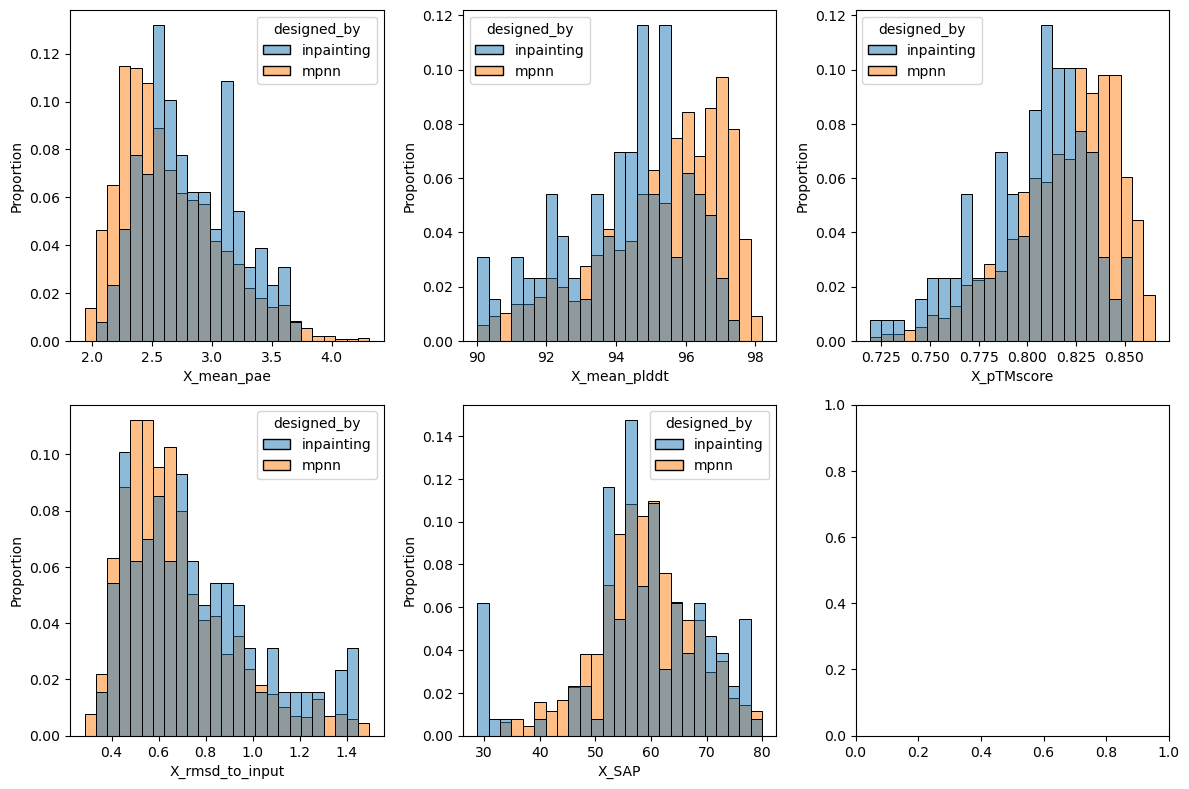

In [6]:
the_fig = histplot_df(
    df=filtered_df,
    cols=cols,
    bins=25,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)
plt.savefig(os.path.join(output_path, "af2_scores.png"))

In [25]:
X_cols = ['X_mean_pae', 'X_mean_plddt', 'X_pTMscore', 'X_rmsd_to_input', 'X_rmsd_to_best', 'X_SAP']
combined_dict = {}
for input_pdb in filtered_df.input_pdb.unique():
    state_df = filtered_df.query(f"input_pdb == '{input_pdb}'").sort_values("X_mean_plddt", ascending=False)
    new_row = state_df.iloc[0, :].copy()
    new_row[X_cols] = state_df[X_cols].mean()
    x_models = np.sort(state_df.X_model.unique())
    new_row["X_models"] = ','.join(x_models.astype(str))
    new_row["num_X_models"] = len(x_models)
    new_row["X_paths"] = ','.join(state_df.index)
    combined_dict[input_pdb] = new_row
combined_df = pd.DataFrame.from_dict(combined_dict, orient="index")

6it [00:00, 23.29it/s]


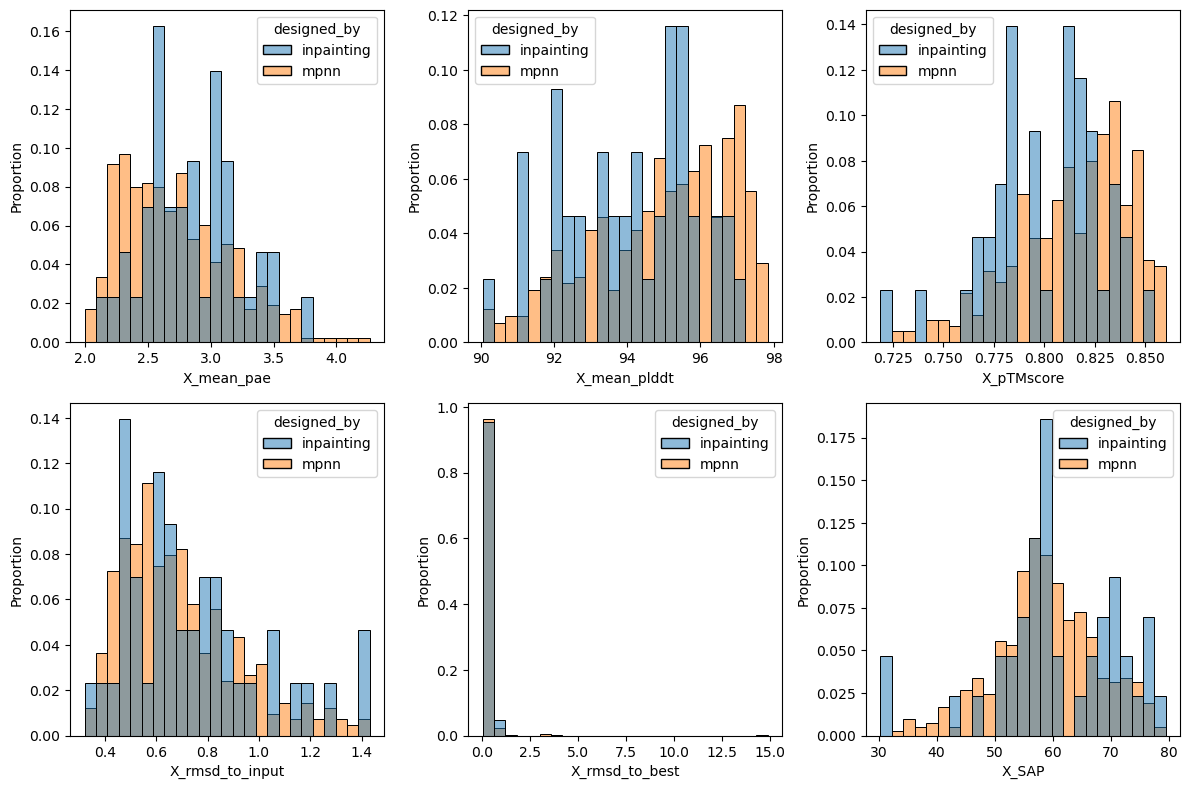

In [42]:
the_fig = histplot_df(
    df=combined_df,
    cols=X_cols,
    bins=25,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)
plt.savefig(os.path.join(output_path, "af2_scores_X.png"))

In [43]:
combined_df = combined_df.query("X_rmsd_to_best < 1")

In [44]:
target_representation = 5

filtered_comb_df = pd.DataFrame()
for parent in combined_df.parent.unique():
    parent_df = combined_df.query(f"parent == '{parent}'")
    for num_models in range(5, 0, -1):
        selected_df = parent_df.query(f"num_X_models >= {num_models}")
        if len(selected_df) >= target_representation:
            break
    filtered_comb_df = pd.concat([filtered_comb_df, selected_df])

In [46]:
filtered_comb_df.parent.value_counts().sort_index()

JHB_07ABr2         40
cs_201r1            3
cs_203r2            7
cs_207_left        14
cs_207_right1      60
cs_207_right2      55
cs_221              7
cs_230_straight     6
cs_230_twist        1
cs_243              5
cs_244_straight     9
cs_244_twist        4
cs_245              2
cs_269_straight    20
cs_269_twist       12
cs_287              5
cs_292              9
Name: parent, dtype: int64

In [47]:
filtering_cols = [
    ("Y_mean_plddt", False),
    ("Y_mean_pae", True),
    ("Y_mean_pae_interaction", True),
    ("X_mean_plddt", False),
    ("X_mean_pae", True),
    ("X_SAP", True),
]

target_representation = 5

all_parents = set(filtered_comb_df.parent.values)
parent_dfs = []
for parent in all_parents:
    parent_df = filtered_comb_df[filtered_comb_df.parent == parent]

    if len(parent_df) > target_representation:
        # find the 10 designs which have all filtering metrics above the quantile cutoff
        filtering_df = pd.DataFrame(columns=[col for col, _ in filtering_cols])
        for col, minimize in filtering_cols:
            if minimize:
                filtering_df[col] = -parent_df[col]
            else:
                filtering_df[col] = parent_df[col]

        filtered_quantile_df = filtering_df
        df_len = len(filtered_quantile_df)
        q = 0.5
        min_q = 0
        max_q = 1
        n_iter = 0
        while df_len != target_representation:
            filtered_quantile_df = filtering_df[filtering_df > filtering_df.quantile(q)].dropna()
            df_len = len(filtered_quantile_df)
            if n_iter > 1000:
                # if it's impossible to distinguish among designs, just take the best by plddt
                filtered_quantile_df = filtering_df[filtering_df > filtering_df.quantile(min_q)].dropna().sort_values(by="Y_mean_plddt", ascending=False).head(target_representation)
                print(f"iteration limit reached for inpaint id {parent} with {df_len} designs at quantile {q}, min_q {min_q}, max_q {max_q}")
                break
            if df_len < target_representation:
                max_q = q
                q = (max_q + min_q) / 2
            elif df_len > target_representation:
                min_q = q
                q = (max_q + min_q) / 2
            n_iter += 1
        
        parent_df = parent_df.loc[filtered_quantile_df.index, :]

    parent_dfs.append(parent_df)

filtered_comb_df = pd.concat(parent_dfs)

iteration limit reached for inpaint id cs_230_straight with 3 designs at quantile 2.3331590462580472e-302, min_q 0, max_q 4.6663180925160944e-302


In [48]:
filtered_comb_df.parent.value_counts().sort_index()

JHB_07ABr2         5
cs_201r1           3
cs_203r2           5
cs_207_left        5
cs_207_right1      5
cs_207_right2      5
cs_221             5
cs_230_straight    3
cs_230_twist       1
cs_243             5
cs_244_straight    5
cs_244_twist       4
cs_245             2
cs_269_straight    5
cs_269_twist       5
cs_287             5
cs_292             5
Name: parent, dtype: int64

In [49]:
from IPython.display import display
with pd.option_context(
    'display.max_columns', None,
):
    display(filtered_comb_df)

,X_SAP,X_mean_pae,X_mean_pae_interaction,X_mean_pae_interaction_AB,X_mean_pae_interaction_BA,X_mean_pae_intra_chain,X_mean_pae_intra_chain_A,X_mean_pae_intra_chain_B,X_mean_plddt,X_model,X_pTMscore,X_recycles,X_rmsd_to_best,X_rmsd_to_input,X_rmsd_to_reference,X_seed,X_tol,X_type,contigs,designed_by,dslf_fa13,elapsed_time,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,inpaint_length,inpaint_mean_lddt,inpaint_seq_resis,inpaint_str_resis,lk_ball_wtd,mean_pae,mean_pae_interaction,mean_pae_interaction_AB,mean_pae_interaction_BA,mean_pae_intra_chain,mean_pae_intra_chain_A,mean_pae_intra_chain_B,mean_plddt,model,mpnn_design_area,mpnn_temperature,omega,pTMscore,p_aa_pp,parent,pro_close,rama_prepro,recycles,ref,rmsd_to_input,rmsd_to_reference,sampled_mask,seed,tol,total_length,total_score,type,yhh_planarity,input_pdb,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_pTMscore,Y_recycles,Y_rmsd_to_reference,Y_seed,Y_tol,X_models,num_X_models,X_paths
/home/broerman/crispy_shifty/projects/DAB/round_1/design/03_fold_complex/decoys/0000/03_fold_complex_d44cbbe0f3f841939bdd69cb604bdfac.pdb.bz2,31.013157,2.546597,NaN,3.416033,3.386772,2.117984,2.117984,3.170887,95.508403,2,0.794419,3.0,0.186789,0.613403,0.558642,0,0.042098,monomer_ptm,"A1-156,0;9-9,B166-169,19-21,C188-191,10-12,D20...",inpainting,0.0,31.350124,-383.148163,135.645508,-125.909927,140.470612,14.919091,199.663834,286.477081,-2.167994,-1.14544,-7.507354,-60.954346,40.0,0.782227,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,14,15,16,17,18,19,20,21,22,2...",-8.585518,2.245856,NaN,3.416033,3.386772,2.117984,2.117984,3.170887,96.881218,2,selection,0.1,14.160288,0.822312,-14.250509,cs_230_straight,0.000000,-27.235088,3.0,-1.680130,0.568867,0.558642,"A1-156,0;9-9,B166-169,20-20,C188-191,11-11,D20...",0,0.042098,227.0,-99.375359,monomer_ptm,2.836956e-07,/home/broerman/crispy_shifty/projects/DAB/roun...,3.229155,3.401402,3.416033,3.386772,2.642916,2.114946,3.170887,95.567932,5.0,0.900846,3.0,0.558642,0.0,0.279961,"1,2,3,4,5",5,/home/broerman/crispy_shifty/projects/DAB/roun...
/home/broerman/crispy_shifty/projects/DAB/round_1/design/03_fold_complex/decoys/0000/03_fold_complex_30e5d96f5d9246b4a0f37d242e5b1388.pdb.bz2,40.915284,3.146124,NaN,3.738640,3.371694,2.623549,2.623549,3.001678,93.173839,3,0.787736,3.0,0.157667,0.559447,0.893970,0,0.066206,monomer_ptm,"A1-156,0;9-9,B166-169,19-21,C188-191,10-12,D20...",mpnn,0.0,37.797192,-383.094086,129.045547,-123.312195,141.501404,14.423061,201.781219,280.551453,-2.167994,-1.14544,-11.227828,-60.954346,40.0,0.782227,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,14,15,16,17,18,19,20,21,22,2...",-8.019781,2.832005,NaN,3.738640,3.371694,2.623549,2.623549,3.001678,95.053421,3,selection,0.1,14.186590,0.810586,-14.336787,cs_230_straight,0.000000,-26.328722,3.0,5.193630,0.534591,0.893970,"A1-156,0;9-9,B166-169,20-20,C188-191,11-11,D20...",0,0.066206,227.0,-102.509819,monomer_ptm,3.574212e-07,/home/broerman/crispy_shifty/projects/DAB/roun...,3.252510,3.555167,3.738640,3.371694,2.724720,2.447762,3.001678,95.430817,5.0,0.906525,3.0,0.893970,0.0,0.082903,"1,2,3,4,5",5,/home/broerman/crispy_shifty/projects/DAB/roun...
/home/broerman/crispy_shifty/projects/DAB/round_1/design/03_fold_complex/decoys/0000/03_fold_complex_3908901bbeb8461ab4c9b5279d89a771.pdb.bz2,45.680153,2.755588,NaN,4.008259,3.444797,2.455837,2.455837,2.978700,94.970728,2,0.808834,3.0,0.180342,0.640677,0.884978,0,0.060998,monomer_ptm,"A1-156,0;9-9,B166-169,19-21,C188-191,10-12,D20...",mpnn,0.0,37.746716,-386.669922,131.448074,-132.671082,142.920639,14.770700,296.112152,285.974762,-2.167994,-1.14544,-13.009769,-60.954346,40.0,0.782227,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,14,15,16,17,18,19,20,21,22,2...",-5.527259,2.610287

In [50]:
with open(os.path.join(output_path, "selected_structures.list"), "w") as f:
    for path in filtered_comb_df.index:
        print(path, file=f)

In [51]:
# copy designs
import bz2
from collections import defaultdict

# use this to generate unique and informative filenames
parent_counts = defaultdict(lambda: 0)

for index, row in filtered_comb_df.iterrows():
    out_X = f"{output_path}/selected_states/{row.parent}_{parent_counts[row.parent]:02d}_X_{row.X_mean_plddt:.01f}_{row.X_mean_pae:.02f}_{row.X_SAP:.02f}.pdb"
    out_Y = f"{output_path}/selected_states/{row.parent}_{parent_counts[row.parent]:02d}_Y_{row.Y_mean_plddt:.01f}_{row.Y_mean_pae:.02f}_{row.Y_mean_pae_interaction:.02f}.pdb"
    parent_counts[row.parent] += 1
    with open(row["X_paths"].split(',')[0], 'rb') as f_in:
        with open(out_X, 'wb') as f_out:
            f_out.write(bz2.decompress(f_in.read()))
    with open(index, 'rb') as f_in:
        with open(out_Y, 'wb') as f_out:
            f_out.write(bz2.decompress(f_in.read()))